In [64]:
import numpy as np
import pandas as pd
import datetime as dt
import pickle
import matplotlib.pylab as plt
%matplotlib inline

In [534]:
market = pd.read_pickle('market.p')
P = pickle.load( open( "P.p", "rb" ) )


In [532]:

market = market[0:8]

In [535]:
market

,Maturity Dates,Market Quotes,Source,Maturity
0,2012-10-04,0.0950,LIBOR,2012-10-04
1,2012-11-05,0.1160,LIBOR,2012-11-05
2,2013-01-03,0.2230,LIBOR,2013-01-03
3,2013-04-03,0.4380,LIBOR,2013-04-03
4,2013-06-19,99.7860,Futures,2013-06-19
5,2013-09-18,99.7520,Futures,2013-09-18
6,2013-12-18,99.7230,Futures,2013-12-18
7,2014-03-19,99.6690,Futures,2014-03-19
8,2014-10-03,0.4750,Swap,2014-10-03
9,2015-10-05,0.5860,Swap,2015-10-05


In [536]:
def delta(t1,t2):
    return (t2 -t1)/dt.timedelta(360)


In [537]:
spotday = dt.date(2012,10,3)

In [538]:
from abc import ABCMeta, abstractmethod
class Instrument(object):
    __metaclass__ = ABCMeta
    
    def __init__(self, maturity, rate):
        self.maturity = maturity
        self.rate = rate
        self.name = None
    
    def timeofpayments(self):
        pass
    
    def coupons(self):
        pass
    

In [539]:
class LIBOR(Instrument):
    def __init__(self,maturity,rate):
        self.name = "LIBOR"
        self.maturity = maturity
        self.rate = rate
        self.payments = {}
        self.price = 1
        self.payment_days = [maturity]
        
    def print_maturity(self):
        print(self.maturity)
    
    def get_payment_days(self):
        return [self.maturity]
    
    def setup_payments(self,spotday):
        self.payments[self.maturity] = 1 +delta(spotday,self.maturity)*self.rate
        
        
        
        
class FRA(Instrument):
    def __init__(self,maturity,rate):
        self.name = "LIBOR"
        self.maturity = maturity
        self.rate = rate
        self.payment_days = [maturity]
        self.payments = {}
        self.price = 0
        
        
    def print_maturity(self):
        print(self.maturity)
    
    def set_payment_days(self,payment_days):
        self.payment_days = payment_days + self.payment_days
        
    def get_payment_days(self):
        return self.payment_days
    
    def setup_payments(self,spotday):
        self.payments[self.payment_days[-1]] = 1 +delta(self.payment_days[-2],self.payment_days[-1])*self.rate
        self.payments[self.payment_days[-2]] = -1
        
class SWAP(Instrument):
    def __init__(self,maturity,rate):
        self.name = "LIBOR"
        self.maturity = maturity
        self.rate = rate
        self.payment_days = [maturity]
        self.payments = {}
        self.price = 1
        #self.price = 0
        
    def print_maturity(self):
        print(self.maturity)
    
    def set_payment_days(self,payment_days):
        self.payment_days = payment_days + self.payment_days
        
    def get_payment_days(self):
        return self.payment_days 
    
    def setup_payments(self,spotday):
        temp = [spotday] + self.get_payment_days()
        for i in range(1,len(temp)):
            self.payments[temp[i]] = delta(temp[i-1],temp[i])*self.rate
        
        self.payments[temp[-1]] += 1
        #self.payments[temp[0]] = -1
        

In [540]:
list_of_instruments = []
for index, row in market.iterrows():
    if row['Source'] == 'LIBOR':
        instument = LIBOR(row['Maturity'].to_pydatetime().date(),row['Market Quotes']/100)
        list_of_instruments.append(instument)
    if row['Source'] == 'Futures':
        instument = FRA(row['Maturity'].to_pydatetime().date(),(100-row['Market Quotes'])/100)
        instument.set_payment_days(P[index])
        list_of_instruments.append(instument)
    if row['Source'] == 'Swap':
        instument = SWAP(row['Maturity'].to_pydatetime().date(),row['Market Quotes']/100)
        instument.set_payment_days(P[index])
        list_of_instruments.append(instument)



In [541]:
for inst in list_of_instruments:
    inst.setup_payments(spotday)


In [542]:
dates = set()
for istru in list_of_instruments:
    dates.update(istru.get_payment_days())
total = sorted(list(dates))
T = [spotday]+ total

In [543]:
C = np.zeros((len(list_of_instruments),len(total)))
p = np.zeros(len(list_of_instruments))

In [544]:
pd.DataFrame(C)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [545]:
p

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [546]:
for (i,inst) in enumerate(list_of_instruments):
    p[i] = inst.price
    for j in range(len(total)):
        if total[j] in inst.payment_days:
            C[i,j] = inst.payments[total[j]]


In [547]:
pd.DataFrame(C)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.000003,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,1.000106,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.00057,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.0,1.002214,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,-1.0,0.000000,1.000541,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.0,0.000000,-1.000000,1.000627,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,-1.000000,0.000000,1.0007,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,-1.0000,1.000837,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.004816,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.005941,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [548]:
W_diag = [1/np.sqrt(delta(T[i-1],T[i])) for i in range(1,len(T))]

In [549]:
W = np.diag(W_diag)

In [550]:
W

array([[ 18.97366596,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   3.35410197,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   2.47016091, ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.99176941,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.99312707,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.99449032]])

In [551]:
from scipy.sparse import spdiags
#M = np.zeros((len(total), len(total)))

In [552]:
diags = np.array([0, -1])
data = np.array([[1]*len(total),[-1]*len(total)])
M = spdiags(data, diags, len(total), len(total)).toarray()

In [553]:
M_minus = np.linalg.inv(M)

In [554]:
M_minus

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [555]:
W_minus =np.linalg.inv(W)

In [556]:
one = np.zeros(len(total))
one[0] = 1
one = np.atleast_2d(one).T

In [557]:
C.shape

(17, 39)

In [558]:
M_minus.shape

(39, 39)

In [559]:
W_minus.shape

(39, 39)

In [560]:
A = np.dot(np.dot(C,M_minus),W_minus)

In [561]:
A_pseudo = np.dot(A.T, np.linalg.inv(np.dot(A,A.T)))

In [562]:
price = np.atleast_2d(p).T

In [563]:
Delta = np.dot(A_pseudo,price - np.dot(np.dot(C, M_minus),one))

In [564]:
discount_curve = np.dot(M_minus, np.dot(W_minus,Delta) + one)

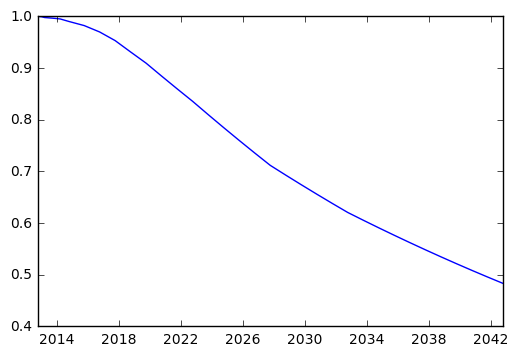

In [565]:
plt.plot(total,discount_curve)

In [566]:
discount_curve

array([[ 0.99999736],
       [ 0.99989368],
       [ 0.99943044],
       [ 0.99783346],
       [ 0.99779056],
       [ 0.99729398],
       [ 0.99666918],
       [ 0.99654594],
       [ 0.99597181],
       [ 0.99513918],
       [ 0.99043078],
       [ 0.98232624],
       [ 0.96994465],
       [ 0.95324658],
       [ 0.9312203 ],
       [ 0.90954951],
       [ 0.88448195],
       [ 0.85988895],
       [ 0.83570089],
       [ 0.81009045],
       [ 0.78484821],
       [ 0.76011331],
       [ 0.73581557],
       [ 0.71188963],
       [ 0.69292841],
       [ 0.67435804],
       [ 0.65612578],
       [ 0.63823162],
       [ 0.62062748],
       [ 0.60563626],
       [ 0.59093169],
       [ 0.57651378],
       [ 0.56234381],
       [ 0.5485    ],
       [ 0.53494284],
       [ 0.52167234],
       [ 0.50865292],
       [ 0.49595651],
       [ 0.48358076]])

In [570]:
(discount_curve[-2]/discount_curve[-1] - 1)/(delta(total[-2],total[-1]))

array([ 0.02531067])

In [569]:
delta(total[-2],total[-1])

1.011111111111111

In [134]:
np.dot(M_minus, W_minus)

array([[ 0.05270463,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.05270463,  0.2981424 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.2981424 ,  0.40483193, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.0082989 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.0082989 ,
         1.0069205 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.0069205 ,  1.00554021]])

In [81]:
p

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [30]:
P[9]

[datetime.date(2013, 10, 3), datetime.date(2014, 10, 3)]

In [98]:
l.setup_payments(dt.date(2015,1,1))

In [99]:
l.payments[dt.date(2015,5,6)]

1.0034722222222223

In [100]:
f = FRA(dt.date(2015,5,6),0.01)

In [101]:
f.set_payment_days([dt.date(2015,3,3)])

In [102]:
f.get_payment_days()

[datetime.date(2015, 3, 3), datetime.date(2015, 5, 6)]

In [103]:
f.setup_payments(dt.date(2015,1,1))

In [104]:
f.price

0

In [105]:
s = SWAP(dt.date(2017,1,1), 0.04)

In [106]:
s.set_payment_days([dt.date(2016,1,1)])

In [107]:
s.get_payment_days()

[datetime.date(2016, 1, 1), datetime.date(2017, 1, 1)]

In [108]:
s.setup_payments(dt.date(2015,1,1))

In [109]:
s.payments

{datetime.date(2016, 1, 1): 0.04055555555555555,
 datetime.date(2017, 1, 1): 1.0406666666666666}

In [110]:
dt.timedelta(30)

datetime.timedelta(30)

In [111]:
def delta(t1,t2):
    return (t2 -t1)/dt.timedelta(360)

In [112]:
delta(dt.date(2015,1,2), dt.date(2015,6,6))

0.4305555555555556

In [113]:
R = {dt.date(2015,1,2):3}

In [114]:
R[dt.date(2015,1,2)]

3

In [115]:
M =[l,f,s]

In [126]:
dates = set()
for istru in M:
    dates.update(istru.get_payment_days())
total = sorted(list(dates))

In [130]:
total = sorted(list(dates))

In [93]:
T = [spotday]+ total

In [94]:
T

[datetime.date(2012, 10, 3),
 datetime.date(2012, 10, 4),
 datetime.date(2012, 11, 5),
 datetime.date(2013, 1, 3),
 datetime.date(2013, 3, 20),
 datetime.date(2013, 4, 3),
 datetime.date(2013, 6, 19),
 datetime.date(2013, 9, 18),
 datetime.date(2013, 10, 3),
 datetime.date(2013, 12, 18),
 datetime.date(2014, 3, 19),
 datetime.date(2014, 10, 3),
 datetime.date(2015, 10, 5),
 datetime.date(2016, 10, 3),
 datetime.date(2017, 10, 3),
 datetime.date(2018, 10, 3),
 datetime.date(2019, 10, 3),
 datetime.date(2020, 10, 3),
 datetime.date(2021, 10, 3),
 datetime.date(2022, 10, 3),
 datetime.date(2023, 10, 3),
 datetime.date(2024, 10, 3),
 datetime.date(2025, 10, 3),
 datetime.date(2026, 10, 3),
 datetime.date(2027, 10, 4),
 datetime.date(2028, 10, 4),
 datetime.date(2029, 10, 4),
 datetime.date(2030, 10, 4),
 datetime.date(2031, 10, 4),
 datetime.date(2032, 10, 4),
 datetime.date(2033, 10, 4),
 datetime.date(2034, 10, 4),
 datetime.date(2035, 10, 4),
 datetime.date(2036, 10, 4),
 datetime.date(

In [92]:
total

[datetime.date(2012, 10, 4),
 datetime.date(2012, 11, 5),
 datetime.date(2013, 1, 3),
 datetime.date(2013, 3, 20),
 datetime.date(2013, 4, 3),
 datetime.date(2013, 6, 19),
 datetime.date(2013, 9, 18),
 datetime.date(2013, 10, 3),
 datetime.date(2013, 12, 18),
 datetime.date(2014, 3, 19),
 datetime.date(2014, 10, 3),
 datetime.date(2015, 10, 5),
 datetime.date(2016, 10, 3),
 datetime.date(2017, 10, 3),
 datetime.date(2018, 10, 3),
 datetime.date(2019, 10, 3),
 datetime.date(2020, 10, 3),
 datetime.date(2021, 10, 3),
 datetime.date(2022, 10, 3),
 datetime.date(2023, 10, 3),
 datetime.date(2024, 10, 3),
 datetime.date(2025, 10, 3),
 datetime.date(2026, 10, 3),
 datetime.date(2027, 10, 4),
 datetime.date(2028, 10, 4),
 datetime.date(2029, 10, 4),
 datetime.date(2030, 10, 4),
 datetime.date(2031, 10, 4),
 datetime.date(2032, 10, 4),
 datetime.date(2033, 10, 4),
 datetime.date(2034, 10, 4),
 datetime.date(2035, 10, 4),
 datetime.date(2036, 10, 4),
 datetime.date(2037, 10, 4),
 datetime.date(

In [124]:
dates.update([1,3,4,5])

In [125]:
dates

{1, 3, 4, 5}

In [132]:
total.index(total[2])

2